In [9]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
from statsmodels.graphics.gofplots import ProbPlot

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

In [10]:
import patsy
from scipy import stats
from sklearn import datasets
from IPython.display import display, HTML

In [11]:
def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')


def diagnostic_plots(X, y, model_fit=None):
  """
  Function to reproduce the 4 base plots of an OLS model in R.

  ---
  Inputs:

  X: A numpy array or pandas dataframe of the features to use in building the linear regression model

  y: A numpy array or pandas series/dataframe of the target variable of the linear regression model

  model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y
  """

  if not model_fit:
      model_fit = sm.OLS(y, sm.add_constant(X)).fit()

  # create dataframe from X, y for easier plot handling
  dataframe = pd.concat([X, y], axis=1)

  # model values
  model_fitted_y = model_fit.fittedvalues
  # model residuals
  model_residuals = model_fit.resid
  # normalized residuals
  model_norm_residuals = model_fit.get_influence().resid_studentized_internal
  # absolute squared normalized residuals
  model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
  # absolute residuals
  model_abs_resid = np.abs(model_residuals)
  # leverage, from statsmodels internals
  model_leverage = model_fit.get_influence().hat_matrix_diag
  # cook's distance, from statsmodels internals
  model_cooks = model_fit.get_influence().cooks_distance[0]

  plot_lm_1 = plt.figure()
  plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                            lowess=True,
                            scatter_kws={'alpha': 0.5},
                            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

  plot_lm_1.axes[0].set_title('Residuals vs Fitted')
  plot_lm_1.axes[0].set_xlabel('Fitted values')
  plot_lm_1.axes[0].set_ylabel('Residuals');

  # annotations
  abs_resid = model_abs_resid.sort_values(ascending=False)
  abs_resid_top_3 = abs_resid[:3]
  for i in abs_resid_top_3.index:
      plot_lm_1.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_residuals[i]));

  QQ = ProbPlot(model_norm_residuals)
  plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
  plot_lm_2.axes[0].set_title('Normal Q-Q')
  plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
  plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
  # annotations
  abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
  abs_norm_resid_top_3 = abs_norm_resid[:3]
  for r, i in enumerate(abs_norm_resid_top_3):
      plot_lm_2.axes[0].annotate(i,
                                 xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                     model_norm_residuals[i]));

  plot_lm_3 = plt.figure()
  plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
  sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
  plot_lm_3.axes[0].set_title('Scale-Location')
  plot_lm_3.axes[0].set_xlabel('Fitted values')
  plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

  # annotations
  abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
  abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
  for i in abs_norm_resid_top_3:
      plot_lm_3.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_norm_residuals_abs_sqrt[i]));


  plot_lm_4 = plt.figure();
  plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
  sns.regplot(model_leverage, model_norm_residuals,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
  plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
  plot_lm_4.axes[0].set_ylim(-3, 5)
  plot_lm_4.axes[0].set_title('Residuals vs Leverage')
  plot_lm_4.axes[0].set_xlabel('Leverage')
  plot_lm_4.axes[0].set_ylabel('Standardized Residuals');

  # annotations
  leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
  for i in leverage_top_3:
      plot_lm_4.axes[0].annotate(i,
                                 xy=(model_leverage[i],
                                     model_norm_residuals[i]));

  p = len(model_fit.params) # number of model parameters
  graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50),
        'Cook\'s distance') # 0.5 line
  graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50)) # 1 line
  plot_lm_4.legend(loc='upper right');

In [12]:
# Functions to emulate R's lm().plot() functionality
# Providing powerful residual plots for simple AND multivariate
# linear regresssion
# - bring your own predictions
# - underlying stats available as pandas dataframe
# - visualise linearity and outliers in multiple dimensions


def lm_stats(X, y, y_pred):
    """ LEVERAGE & STUDENTISED RESIDUALS
    - https://en.wikipedia.org/wiki/Studentized_residual#How_to_studentize
    """
    # Responses as np array vector
    try: 
        y.shape[1] == 1
        # take first dimension as vector
        y = y.iloc[:,0]
    except:
        pass
    y = np.array(y)
    
    # Residuals
    residuals = np.array(y - y_pred)
    
    # Hat matrix
    H = np.array(X @ np.linalg.inv(X.T @ X)) @ X.T
    
    # Leverage
    h_ii = H.diagonal()
    
    ## Externally studentised residual
    # In this case external studentisation is most appropriate 
    # because we are looking for outliers.
    
    # Estimate variance (externalised)
    σi_est = []
    for i in range(X.shape[0]):
        # exclude ith observation from estimation of variance
        external_residuals = np.delete(residuals, i)
        σi_est += [np.sqrt((1 / (X.shape[0] - X.shape[1] - 1)) * np.sum(np.square(external_residuals)))]
    σi_est = np.array(σi_est)
    
    # Externally studentised residuals
    t = residuals / σi_est * np.sqrt(1 - h_ii)
    

    # Return dataframe
    return pd.DataFrame({'residual': residuals,
                         'leverage': h_ii, 
                         'studentised_residual': t,
                         'y_pred': y_pred})


def lm_plot(lm_stats_df): 
    """Provides R style residual plots based on results from lm_stat()"""
    # Parse stats
    t      = lm_stats_df['studentised_residual']
    h_ii   = lm_stats_df['leverage']
    y_pred = lm_stats_df['y_pred']
    
    # setup axis for grid
    plt.figure(1, figsize=(16, 18))
    
    # Studentised residual plot
    plt.subplot(321)
    ax = sns.regplot(x=y_pred, y=t, lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual plot', fontweight='bold')
    # Draw Hastie and Tibshirani's bounds for possible outliers
    ax.axhline(y=3, color='r', linestyle='dashed')
    ax.axhline(y=-3, color='r', linestyle='dashed');
    
    # Normal Q-Q plot
    plt.subplot(322)
    ax = stats.probplot(t, dist='norm', plot=plt)
    plt.ylabel('Studentised residuals')
    plt.title('Normal Q-Q', fontweight='bold')
    
    # Standardised residuals
    plt.subplot(323)
    ax = sns.regplot(x=y_pred, y=np.sqrt(np.abs(t)), lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('√Standardized residuals')
    plt.title('Scale-Location', fontweight='bold')
    
    # Residuals vs Leverage plot
    plt.subplot(324)
    ax = sns.scatterplot(x=h_ii, y=t)
    plt.xlabel('Leverage')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual vs Leverage', fontweight='bold');

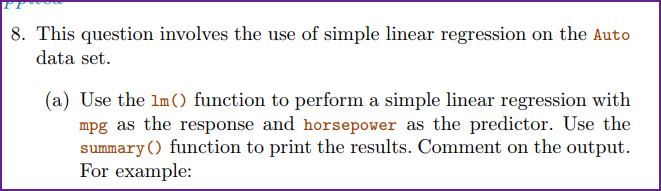

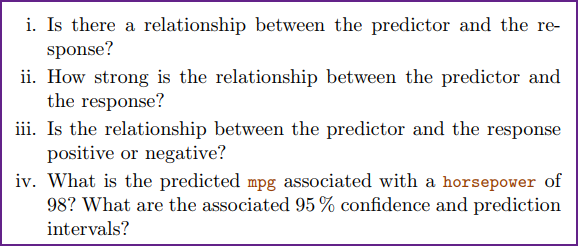

In [13]:
 # A coluna horsepower tinha ? em algumas linhas
auto = pd.read_csv('Data/Auto.csv',na_values=['?'],dtype={'horsepower':np.float64})

In [14]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [15]:
est = smf.ols(formula='mpg ~ horsepower',data=auto).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Thu, 02 Apr 2020   Prob (F-statistic):           7.03e-81
Time:                        08:02:18   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# i.
Yes, there is a relationship between horsepower and mpg as deterined by testing the null hypothesis of all regression coefficients equal to zero. Since the F-statistic is far larger than 1 and the p-value of the F-statistic is close to zero we can reject the null hypothesis and state there is a statistically significant relationship between horsepower and mpg.

# ii.
To calculate the residual error relative to the response we use the mean of the response and the RSE. The mean of mpg is 23.4459. The RSE of the lm.fit was 4.906 which indicates a percentage error of 20.9248%. The R2 of the lm.fit was about 0.6059, meaning 60.5948% of the variance in mpg is explained by horsepower.

In [16]:
# RSE
np.sqrt(est.mse_resid)

4.90575691954594

In [17]:
# % do RSE
np.sqrt(est.mse_resid)/np.mean(auto.mpg)*100

20.86147407891919

# iii.
The relationship between mpg and horsepower is negative. The more horsepower an automobile has the linear regression indicates the less mpg fuel efficiency the automobile will have.

# iv. 
What is the predicted mpg associated with a horsepower of
98? What are the associated 95 % confidence and prediction
intervals?

In [18]:
est.predict({'horsepower':98})

0    24.467077
dtype: float64

In [19]:
pred = est.get_prediction({'horsepower':98})
pred.conf_int()

array([[23.97307896, 24.96107534]])

In [20]:
#mean_ci_lower - mean_ci_upper - confidence interval
#obs_ci_lower - obs_ci_upper - Predict interval
pred.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,24.467077,0.251262,23.973079,24.961075,14.809396,34.124758


# b)
Plot the response and the predictor. Use the abline() function
to display the least squares regression line.

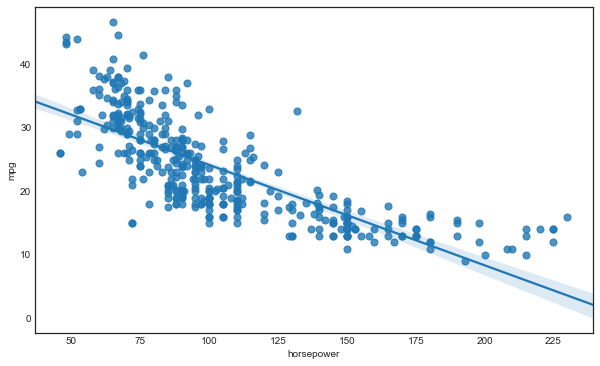

In [21]:
plt.figure(figsize=(10,6))
sns.regplot(x=auto.horsepower,y=auto.mpg,scatter_kws={'s':50})

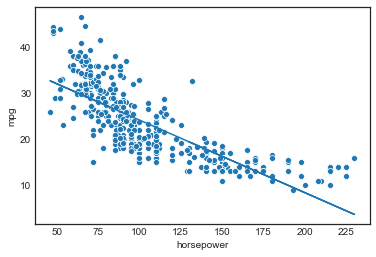

In [22]:
# Let's plot our predicted regression

df = pd.concat([auto['horsepower'], auto['mpg']], axis=1)
ax = sns.scatterplot(x='horsepower', y='mpg', data=df)
ax.plot(auto[auto.horsepower.notnull()].horsepower,est.predict() );

# c)
Use the plot() function to produce diagnostic plots of the least
squares regression fit. Comment on any problems you see with
the fit.

In [23]:
auto2 = auto.copy()
auto2 = auto2.dropna(subset=['horsepower'])
auto2 = auto2.reset_index()

In [24]:
X = pd.DataFrame(auto2.horsepower)
y = pd.DataFrame(auto2.mpg)

# generate OLS model
model = sm.OLS(y, sm.add_constant(X))
model_fit = model.fit()

# create dataframe from X, y for easier plot handling
dataframe = pd.concat([X, y], axis=1)

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


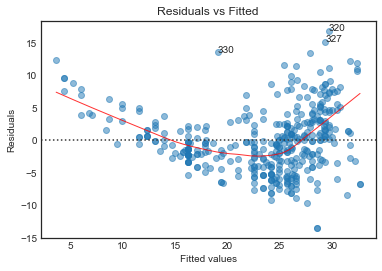

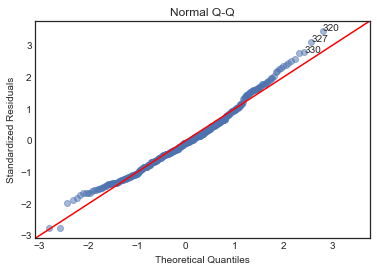

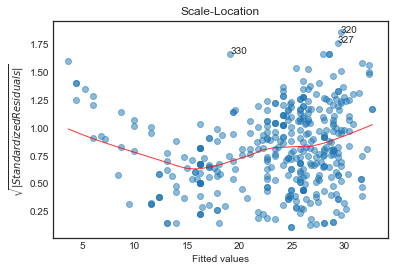

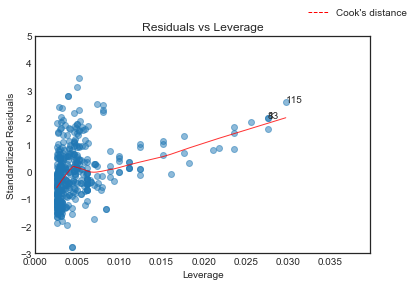

In [25]:
diagnostic_plots(X,y)

Based on the residuals plots, there is some evidence of non-linearity.

In [8]:
X = pd.concat([auto2['horsepower']], axis=1)
# Create the Design Matrix by adding constant bias variable
intercept_const = pd.DataFrame({'intercept': np.ones(X.shape[0])})
X = np.array(pd.concat([intercept_const, X], axis=1))

y = auto2['mpg']

lm_plot(lm_stats(X, y, est.predict()))

NameError: name 'auto2' is not defined


The above residual plot grid shows the relationship between the horsepower predictor and the mpg response. There are several things to note:

- **Non-linearity of the data:** The top-left residual plot exhibits a discernable pattern, in this case u-shaped, that suggests our linear model is not providing a optimal fit to our data - the relationship is non-linear. A discernable pattern in this plot suggests that our model is failing to account for some of the reducible variance in the responses. There is still a discernable pattern in the bottom-left plot suggesting that a quadratic transform only improves the fit of our model slightly.
- **Heteroscedasticity** – Non-constant variance of error terms The top-left residual plot exhibits a conical shape. This suggests that there is some heteroscedasticity in our predictor. The standardised plot (bottom-left) also exhibits this characteristic suggesting that standardisation doesn't alleviate the issue – to address this we might consider fitting our model by weighted least squares.
- **Outliers and leverage:** the bottom-right residual vs leverage plot suggests that there are several potential outliers (points in top-right of axis) that could be having a strong effect (leverage) on our model. We should add more predictors to our model to clarify outliers.
- The top-right plot shows that our studentised residuals have a slightly non-normal distribution (TODO: ellaborate)

# 9.(a) 
Produce a scatterplot matrix which includes all of the variables
in the data set

C:\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


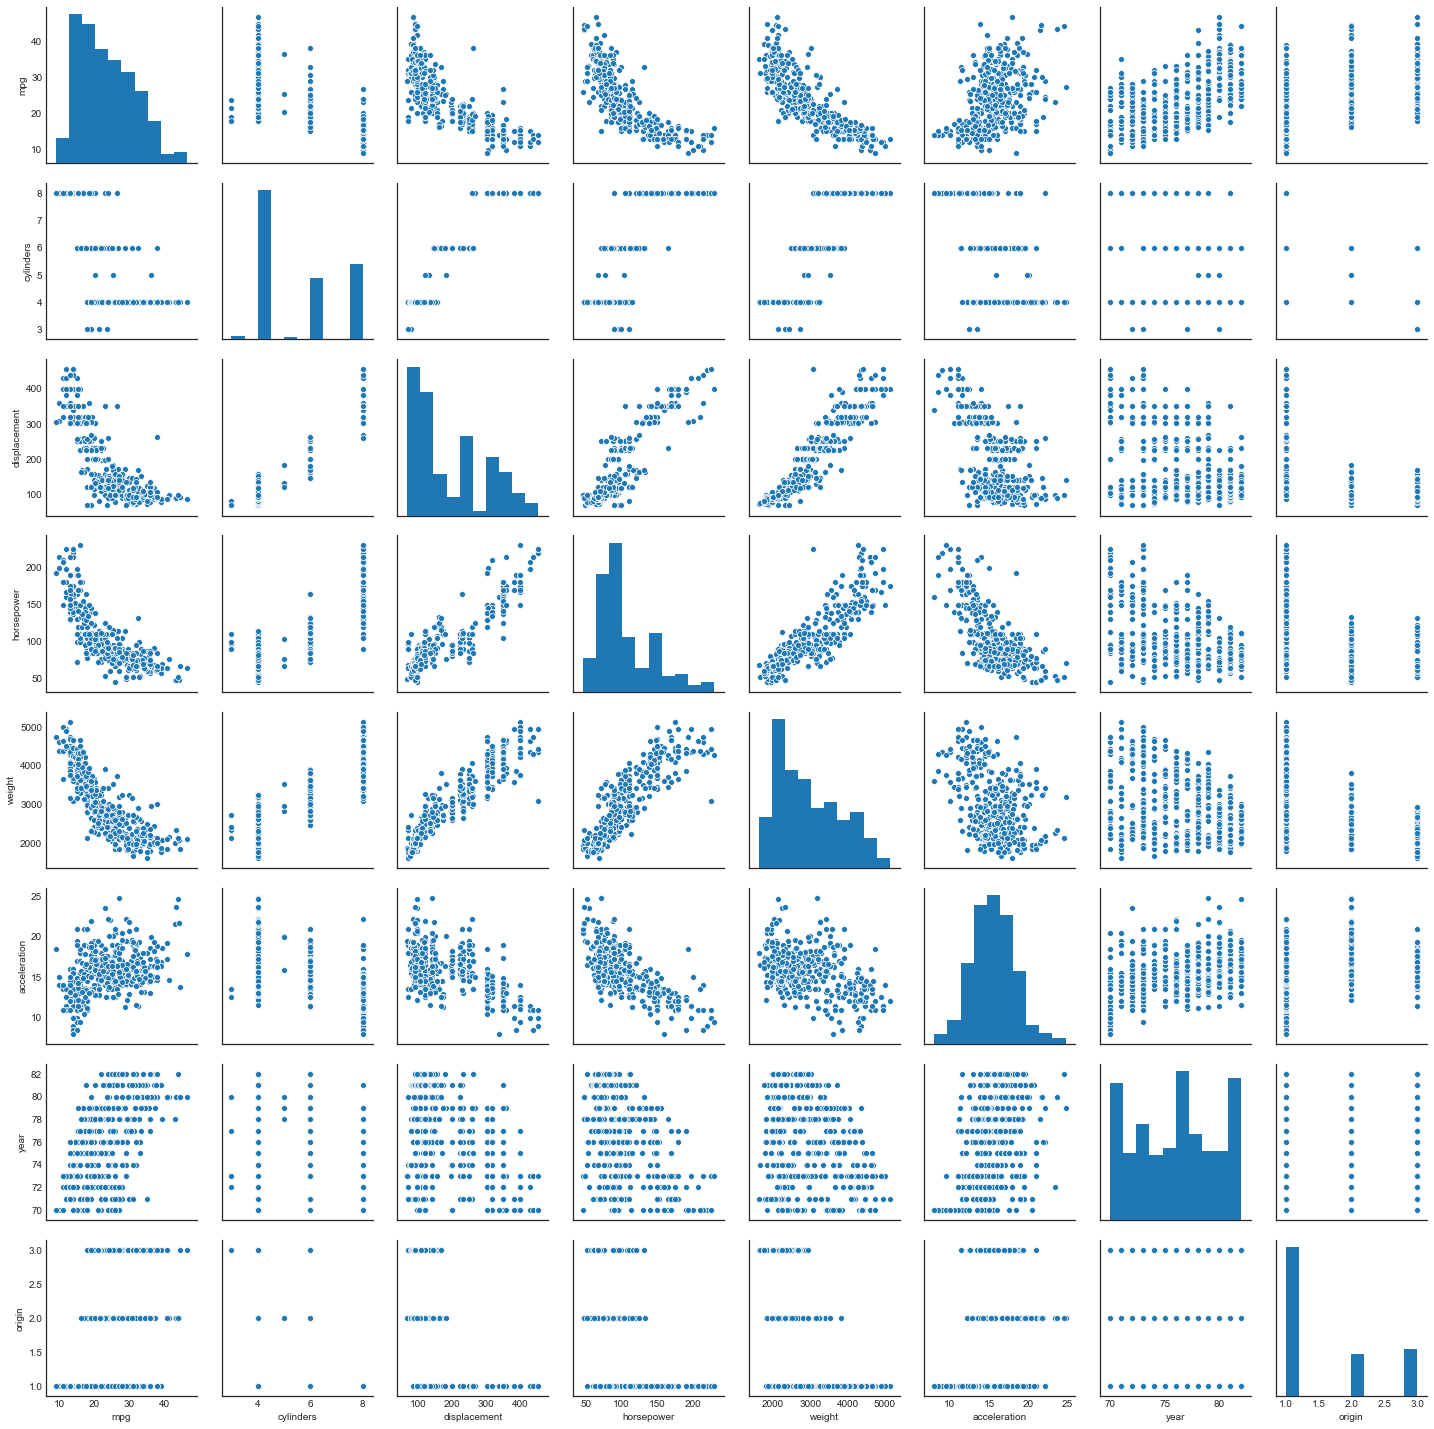

In [263]:
sns.pairplot(auto)

# (b) 
Compute the matrix of correlations between the variables using
the function cor(). You will need to exclude the name variable,
cor()
which is qualitative.

In [264]:
auto.corr().abs()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,0.776260,0.804443,0.778427,0.831739,0.422297,0.581469,0.563698
cylinders,0.776260,1.000000,0.950920,0.842983,0.897017,0.504061,0.346717,0.564972
displacement,0.804443,0.950920,1.000000,0.897257,0.933104,0.544162,0.369804,0.610664
horsepower,0.778427,0.842983,0.897257,1.000000,0.864538,0.689196,0.416361,0.455171
weight,0.831739,0.897017,0.933104,0.864538,1.000000,0.419502,0.307900,0.581265
acceleration,0.422297,0.504061,0.544162,0.689196,0.419502,1.000000,0.282901,0.210084
year,0.581469,0.346717,0.369804,0.416361,0.307900,0.282901,1.000000,0.184314
origin,0.563698,0.564972,0.610664,0.455171,0.581265,0.210084,0.184314,1.000000


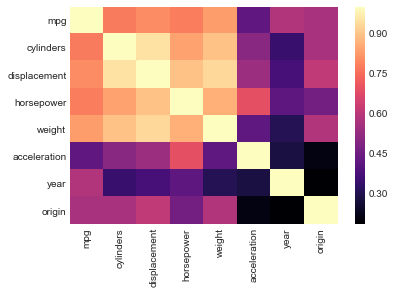

In [265]:
sns.heatmap(auto.corr().abs(),cmap='magma')

# c)

In [266]:
auto.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin', 'name'],
      dtype='object')

In [267]:
X = auto[['cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin']]
X.insert(0,column='Ones',value=1)
y = auto.mpg

In [268]:
' + '.join(X.columns)

'Ones + cylinders + displacement + horsepower + weight + acceleration + year + origin'

In [269]:
est = smf.ols(formula = 'mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + C(origin)',data=auto).fit()

In [270]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     224.5
Date:                Mon, 26 Aug 2019   Prob (F-statistic):          1.79e-139
Time:                        20:46:10   Log-Likelihood:                -1020.5
No. Observations:                 392   AIC:                             2059.
Df Residuals:                     383   BIC:                             2095.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -17.9546      4.677     -3.839      0.000     -27.150      -8.759
C(origin)[T.2]     2.6300      0.566      4.643      0.000       1.516       3.744
C(origin)[T.3]     2.8532      0.553      5.162      0.000       1.766       3.940
cylinders         -0.4897      0.321     -1.524      0.128      -1.121       0.142
displacement       0.0240      0.008      3.133      0.002       0.009       0.039
horsepower        -0.0182      0.014     -1.326      0.185      -0.045       0.009
weight            -0.0067      0.001    -10.243      0.000      -0.008      -0.005
acceleration       0.0791      0.098      0.805      0.421      -0.114       0.272
year               0.7770      0.052     15.005      0.000       0.675       0.879
==============================================================================
Omnibus:                       23.395   Durbin-Watson:                   1.291
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.452
Skew:                           0.444   Prob(JB):                     3.30e-08
Kurtosis:                       4.150   Cond. No.                     8.70e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.7e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- i. Is there a relationship between the predictors and the response?
**Sim, F-statistic é muito pequena.**

- ii. Which predictors appear to have a statistically significant relationship to the response?

In [271]:
est.pvalues[est.pvalues < 0.05].sort_values()

year              2.332943e-40
weight            6.375633e-22
C(origin)[T.3]    3.933208e-07
C(origin)[T.2]    4.720373e-06
Intercept         1.445124e-04
displacement      1.862685e-03
dtype: float64

- iii. What does the coefficient for the year variable suggest? **Quanto mais novo o carro, mais eficiente é o consumo de combustivel.**

# (d) 
Use the plot() function to produce diagnostic plots of the linear
regression fit. Comment on any problems you see with the fit.
Do the residual plots suggest any unusually large outliers? Does
the leverage plot identify any observations with unusually high
leverage?

In [299]:
X.dropna(inplace=True)
i = np.array(X.index)
y = y.loc[i]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


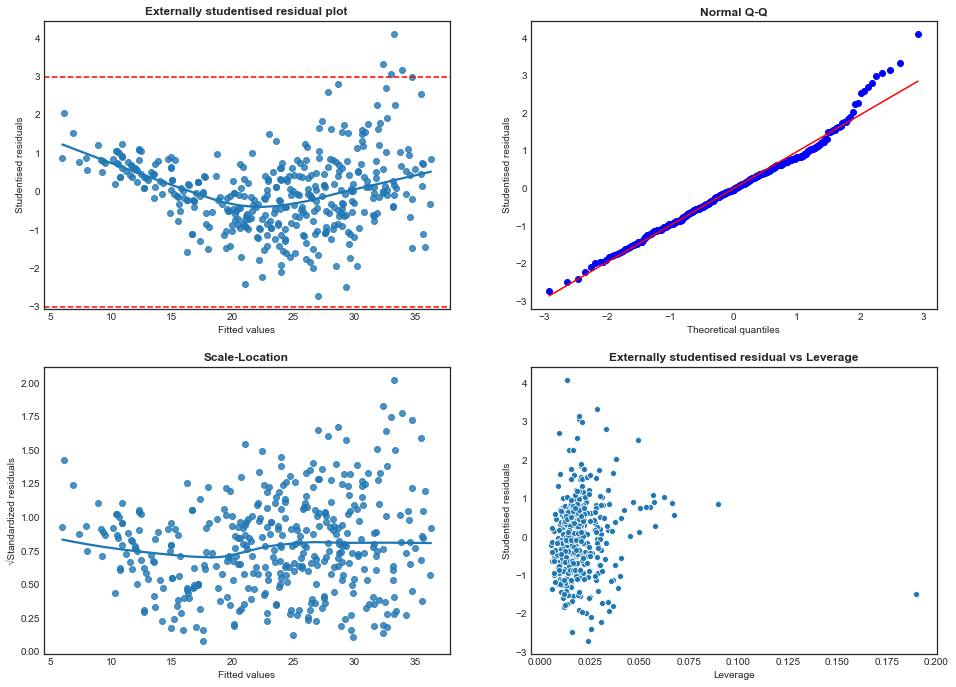

In [306]:
# Make predictions
y_pred = np.array(est.predict())

# Analyse residuals
lm_plot(lm_stats(X.values, y, y_pred))

- **Linearity:** The u-shaped pattern in the top-left residual plot suggests that there a non-linear relationship that our model is unable to account for. The bottom left Scale-Location plot suggests that a square-root transform reduces the non-linearity of this relationship allowing our model to achieve an improved fit.
- **Heteroscedasticity:** A conical pattern is apparent in the top-left plot suggesting that variance of residuals increases with response. The bottom left plot suggests that a square-root transform helps to mitigate this effect.
- **Outliers:** The top-left plot suggests that there are five potential outliers towards the high end of our predicted responses. The bottom-right plot suggests that these outliers have low leverage, and so probably don't have a overly dispraportionate effect on our model.
- **Leverage:** The bottom right plot reveals one point with particularly high leverage, although with a value around -1.2 this point isn't an outlier in terms of studentised residuals.
- **Normality:** The top-right plot shows a normal distribution except for high value residuals. This suggests that the model under-estimates `mpg` for a larger number of observations than we might expect assuming a normal distribution.


# (e)

In [316]:
auto_df = df.copy()

In [317]:
# Let's fit a model with all possible interaction effects

f = 'np.log1p(mpg) ~ cylinders + displacement + horsepower + weight + acceleration + year + C(origin) \
    + cylinders*displacement \
    + cylinders*horsepower \
    + cylinders*weight \
    + cylinders*acceleration \
    + cylinders*year \
    + displacement*horsepower \
    + displacement*weight \
    + displacement*acceleration \
    + displacement*year \
    + horsepower*weight \
    + horsepower*acceleration \
    + horsepower*year \
    + weight*weight \
    + weight*acceleration \
    + weight*year \
    + acceleration*year \
    '

#y, X = patsy.dmatrices(f, auto_df, return_type='dataframe')
model = smf.ols(formula=f,data=auto).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log1p(mpg)   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     152.3
Date:                Mon, 26 Aug 2019   Prob (F-statistic):          2.31e-172
Time:                        21:48:13   Log-Likelihood:                 346.65
No. Observations:                 392   AIC:                            -645.3
Df Residuals:                     368   BIC:                            -550.0
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     3.7093      1.873      1.981      0.048       0.027       7.392
C(origin)[T.2]                0.0367      0.020      1.799      0.073      -0.003       0.077
C(origin)[T.3]                0.0333      0.019      1.720      0.086      -0.005       0.071
cylinders                     0.3466      0.310      1.119      0.264      -0.262       0.955
displacement                 -0.0124      0.007     -1.826      0.069      -0.026       0.001
horsepower                    0.0088      0.012      0.721      0.472      -0.015       0.033
weight                       -0.0001      0.001     -0.225      0.822      -0.001       0.001
acceleration                 -0.2061      0.080     -2.591      0.010      -0.363      -0.050
year                          0.0111      0.022      0.507      0.613      -0.032       0.054
cylinders:displacement       -0.0005      0.000     -2.604      0.010      -0.001      -0.000
cylinders:horsepower          0.0006      0.001      0.633      0.527      -0.001       0.002
cylinders:weight           1.701e-05   3.11e-05      0.546      0.585   -4.42e-05    7.82e-05
cylinders:acceleration        0.0098      0.006      1.555      0.121      -0.003       0.022
cylinders:year               -0.0068      0.004     -1.897      0.059      -0.014       0.000
displacement:horsepower    2.538e-06   1.08e-05      0.235      0.814   -1.87e-05    2.38e-05
displacement:weight        9.392e-07   5.18e-07      1.813      0.071   -7.97e-08    1.96e-06
displacement:acceleration    -0.0002      0.000     -1.876      0.062      -0.000    1.09e-05
displacement:year             0.0002   8.32e-05      2.377      0.018    3.42e-05       0.000
horsepower:weight         -1.528e-06   1.07e-06     -1.431      0.153   -3.63e-06    5.71e-07
horsepower:acceleration      -0.0002      0.000     -1.158      0.248      -0.000       0.000
horsepower:year              -0.0001      0.000     -0.723      0.470      -0.000       0.000
weight:acceleration         5.38e-06   8.74e-06      0.615      0.539   -1.18e-05    2.26e-05
weight:year               -3.245e-06   8.01e-06     -0.405      0.686    -1.9e-05    1.25e-05
acceleration:year             0.0024      0.001      2.553      0.011       0.001       0.004
==============================================================================
Omnibus:                       12.734   Durbin-Watson:                   1.605
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               25.323
Skew:                          -0.092   Prob(JB):                     3.17e-06
Kurtosis:                       4.232   Cond. No.                     3.46e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the

In [318]:
# If we take p < 0.05 as our significance threshold
# which features appear as significant in this model?
model.pvalues[model.pvalues < 0.05].sort_values()

cylinders:displacement    0.009575
acceleration              0.009944
acceleration:year         0.011091
displacement:year         0.017965
Intercept                 0.048352
dtype: float64

Only the above features seem to be statistically significant in this model.

Notice the warning (2) that suggests the might be multicollinearity in this model. We can observe in the correlation plot above that there is strong collinearity between mpg, cylinders, displacement, horespower, and weight. This means further investigation is required to discern which, if any, of these features have a *causal* relationship with our response `mpg`.  